In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%config Completer.use_jedi = False

In [4]:
# https://pythonprogramming.net/building-deep-learning-neural-network-pytorch/?completed=/data-deep-learning-neural-network-pytorch/

In [2]:
train = datasets.MNIST(root='data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST(root='data', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))


trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # it will expect a flatten tensor 
        self.fc1 = nn.Linear(28*28, 64)  # 28x28 is the image size
        self.fc2 = nn.Linear(64, 64)  # 64 is the size of the previous layer
        self.fc3 = nn.Linear(64, 64)  # the size is arbitrary at this stage
        self.fc4 = nn.Linear(64, 10)  # 10 are the labels at the end
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1)  # to get a prob distribution

net = Net()
net

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
X = torch.randn((28,28))
output = net(X)  # should break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 784x64)

In [6]:
X = X.view(-1,28*28)  # -1 for 'any size', it can be the batch size
output = net(X)
output

tensor([[-2.2300, -2.4379, -2.2416, -2.2747, -2.2005, -2.2934, -2.1524, -2.3423,
         -2.3952, -2.5150]], grad_fn=<LogSoftmaxBackward>)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [8]:
model = Net().to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
X = torch.rand(28, 28, device=device).view(-1,28*28)
logits = model(X)
logits

tensor([[-2.3897, -2.2036, -2.1310, -2.3935, -2.3168, -2.2044, -2.3924, -2.3473,
         -2.4099, -2.2814]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

# Training

In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.001)  # parameters is everything adjustable, in transfer learning for example not everything is adjustable

EPOCHS = 10

for epoch in range(EPOCHS): # 3 full passes over the data
    for X, y in trainset:  # `data` is a batch of data
        # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        
        output = net(X.view(-1, 28*28))  # pass in the reshaped batch (recall they are 28x28 atm)
        
        loss = F.nll_loss(output, y)  # calc and grab the loss value, negative log likelihood
        
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
        
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines!

tensor(0.0003, grad_fn=<NllLossBackward>)
tensor(0.0004, grad_fn=<NllLossBackward>)
tensor(0.0610, grad_fn=<NllLossBackward>)
tensor(0.2628, grad_fn=<NllLossBackward>)
tensor(0.0002, grad_fn=<NllLossBackward>)
tensor(5.0824e-05, grad_fn=<NllLossBackward>)
tensor(2.5986e-05, grad_fn=<NllLossBackward>)
tensor(0.0037, grad_fn=<NllLossBackward>)
tensor(0.0006, grad_fn=<NllLossBackward>)
tensor(0.0015, grad_fn=<NllLossBackward>)


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.974


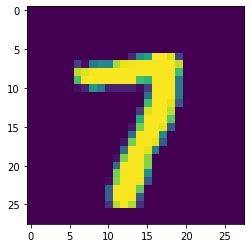

In [16]:
import matplotlib.pyplot as plt

plt.imshow(X[0].view(28,28))
plt.show()

In [17]:
print(torch.argmax(net(X[0].view(-1,784))[0]))

tensor(7)
